In [10]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [11]:
import numpy as np
import matplotlib.pyplot as plt

When a approaching a new problem, the first step is to generally write down the
_likelihood function_ (the probability of a dataset given the model parameters).
This is equivalent to describing the generative procedure for the data. In this
case, we're going to consider a linear model where the quoted uncertainties are
underestimated by a constant fractional amount.

We can generate a synthetic dataset from this model:

Text(0, 0.5, 'y')

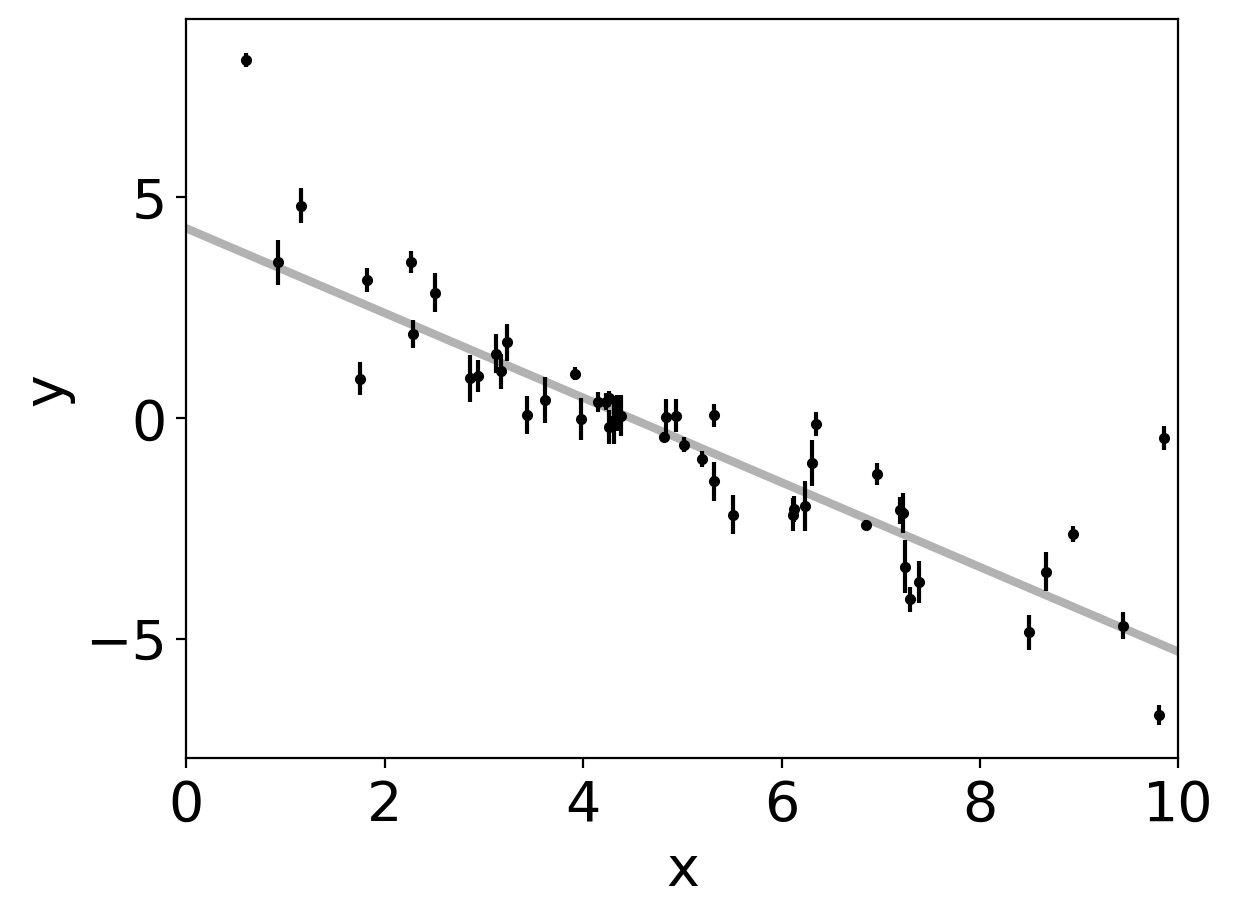

In [12]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

The standard way to fit a line to these data (assuming independent Gaussian error bars) is
linear least squares. Linear least squares is appealing because solving for the parameters
and their associated uncertainties—is simply a linear algebraic operation. The linear least
squares solution to these data is;

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


Text(0, 0.5, 'y')

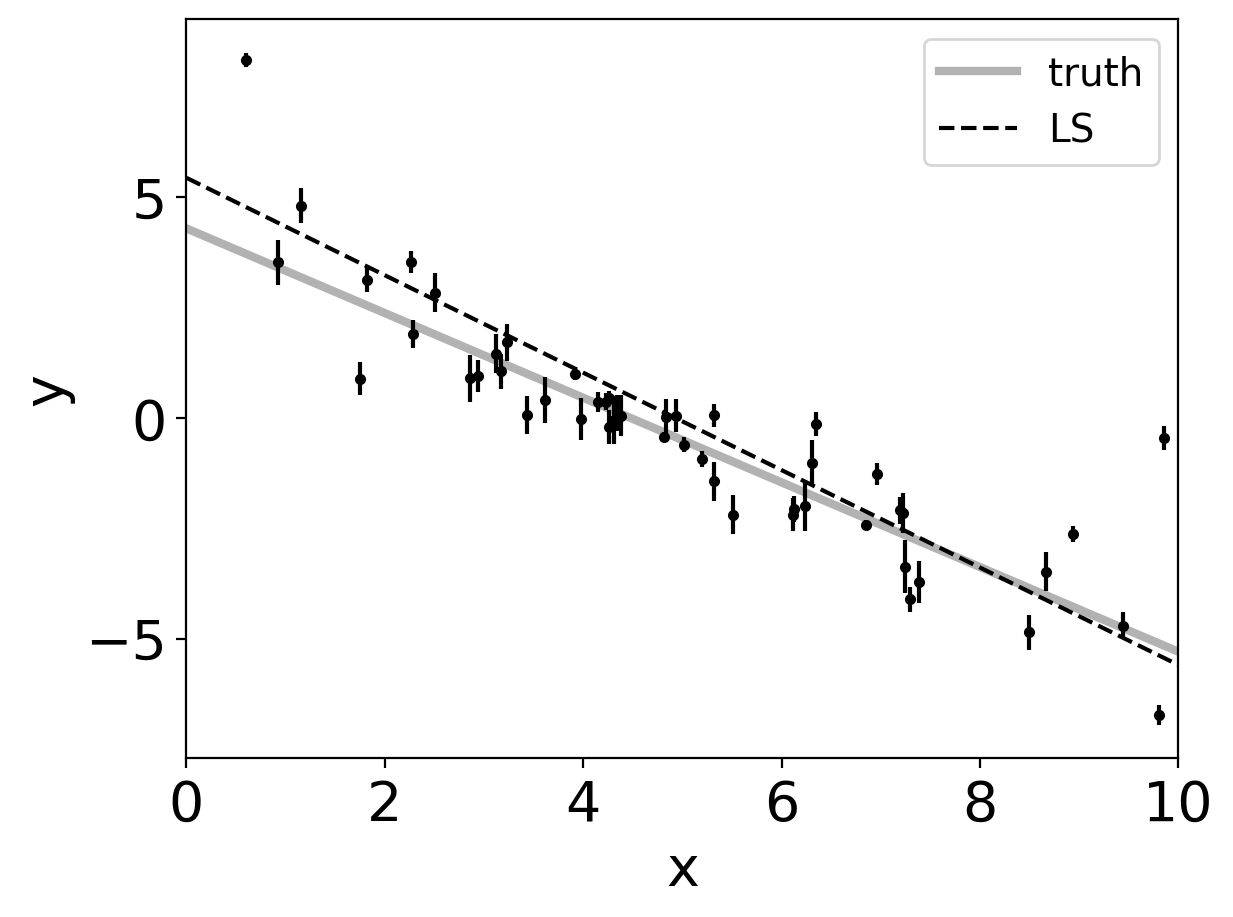

In [13]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Not too bad but the uncertainties on the slope are a little small (because
of the small error bars on most of the datapoints).

### Maximum likelihood estimation
The least squares solution is the maximum likelihood result for a model where the
errorbars are assumed to be correct, Gaussian and independent. We know, of course,
that this isn't the right model. Unfortunately, there isn't a generalization of
least squares that supports a model like the one we know to be true.

We need to write down the **likelihood function** and numerically optimize it. In
mathematical notation, the correct likelihood function is:
$$
\ln{ p(y \,|\, x, \sigma, m, b, f) } = -\frac{1}{2} \sum_{n} \left[ \frac{(y_n - (m x_n + b))^2}{s_n^2} + \ln{(s_n^2)} \right]
$$
where
$$
s_n^2 = \sigma_n^2 + f^2(m x_n + b)^2
$$
This is simply a Gaussian where the variance is underestimated by some fractional
amount: $f$. In Python, this can be coded as:

In [14]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    # The equation above for s^2_n = \sigma^2_n + ((m * x_n + b)^2) * f^2
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)

    # The likelihood function above: for ln p(y|x, \sigma, m, b, f)
    return -0.5 * np.sum(((y - model)**2 / sigma2) + np.log(sigma2))

We use the log of $f$ rather the $f$ directly as that is what emcee expects, plus
it ensures that it is always positive.

A good way of finding the numerical optimum of the likelihood function is to use
the `scipy.optimize` module:

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


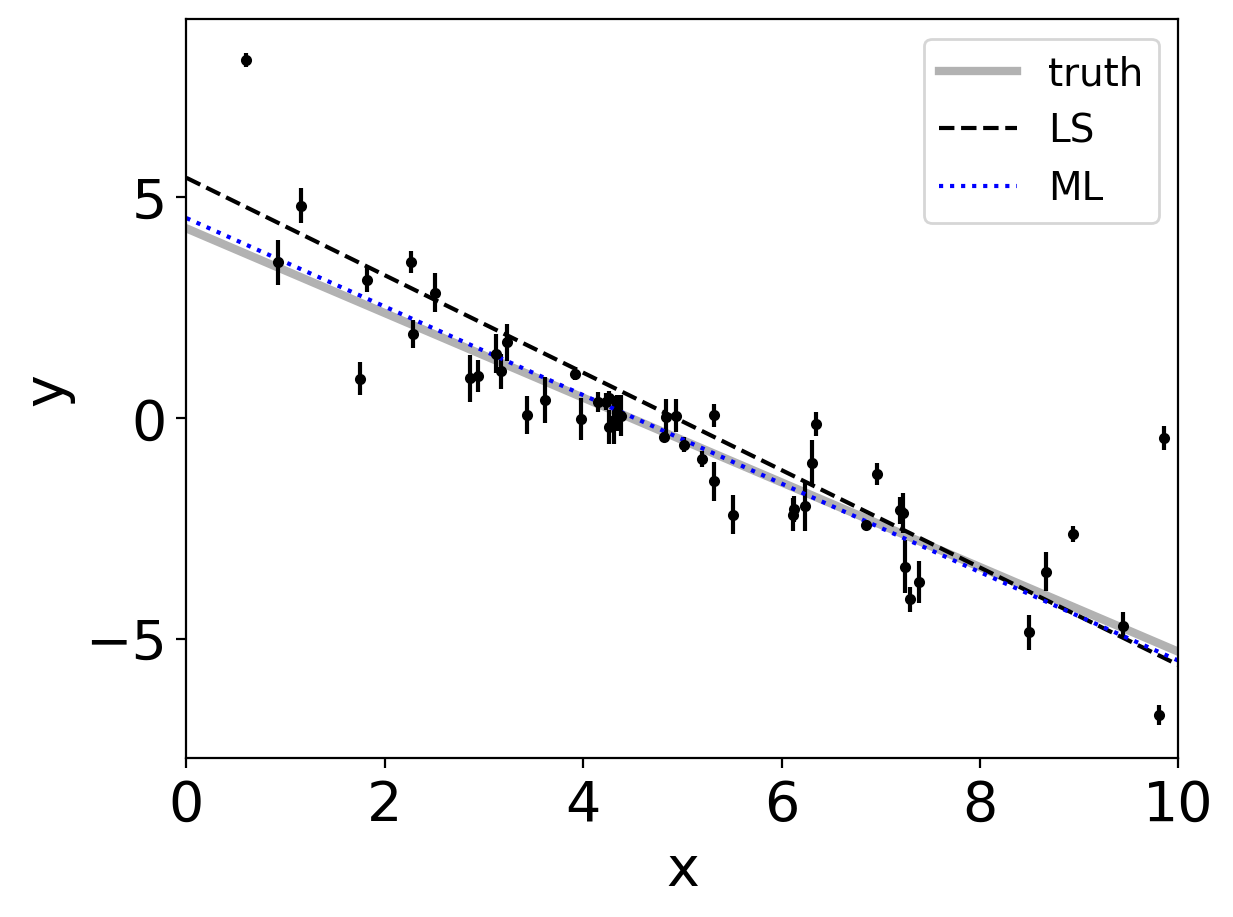

In [15]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":b", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

It’s worth noting that the optimize module minimizes functions whereas we would like to
maximize the likelihood.  This goal is equivalent to minimizing the negative likelihood
(or in this case, the negative log likelihood). In this figure, the maximum likelihood
(ML) result is plotted as a dotted blue line — compared to the true model (grey line) and
linear least-squares (LS; dashed line). That looks better!

The problem now: how do we estimate the uncertainties on m and b? What’s more, we probably
don’t really care too much about the value of f but it seems worthwhile to propagate any
uncertainties about its value to our final estimates of m and b. This is where MCMC comes in.

### Marginalization & uncertainty estimation
This isn’t the place to get into the details of why you might want to use MCMC in
your research but it is worth commenting that a common reason is that you would like
to marginalize over some “nuisance parameters” and find an estimate of the posterior
probability function (the distribution of parameters that is consistent with your
dataset) for others.

MCMC lets you do both of these things in one fell swoop! You need to start by writing
down the posterior probability function (up to a constant):
$$
p(m, b, f \,|\, x, y, \sigma) \propto p(m, b, f) \, p(y \,|\, x, \sigma, m, b, f)
$$

We already have the likelihood function (previous section); $p(y \,|\, x, \sigma, m, b, f)$


The missing component is the "prior" function; $p(m, b, f)$

This encodes any previous knowledge that we have about the parameters: results
from other experiments, physically acceptible ranges, etc.

It's necessary to write down the priors if we're going to use MCMC because
all that MCMC does is draw samples from a probability distribution which
we want to be for the parameters.

__IMPORTANT: you cannot draw parameter samples from the likelihood function.__
This is because a likelihood function is a probability distribution over datasets
so, conditioned on model parameters, you can draw representative datasets (as
demonstrated at the beginning of this exercise) but you cannot draw parameter samples.

In this example, we’ll use uniform (so-called “uninformative”) priors on $m$,
$b$ and the log of $f$. For example, we’ll use the following conservative prior on $m$:
$$
p(m) = \frac{1}{5.5} \, {\rm if} \, -5<m<\frac{1}{2} \, {\rm else} \, 0
$$

In code, the log-prior is (up to a constant):

In [16]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 \
            and 0.0 < b < 10.0 \
            and -10.0 < log_f < 1.0:
        return 0.0 # log(1)
    return -np.inf # log(0)

In combination with the definition of the log-likelihood from above,
the full log-probability function is:

In [17]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

### Running MCMC
After all this setup, it’s easy to sample this distribution using emcee.
We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum
likelihood result (I’ve found that this tends to be a pretty good initialization
in most cases) and then run 5,000 steps of MCMC.

In [18]:
import emcee

# soln is the maximum likelihood result from scipy minimize()
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:02<00:00, 1797.60it/s]


State([[-0.96221813  4.25254622 -0.85254086]
 [-1.15154403  5.21865678 -0.81876194]
 [-1.11459806  5.00265056 -0.7433076 ]
 [-1.01881825  4.57086385 -0.80853933]
 [-1.15027055  5.22093137 -0.9448669 ]
 [-0.98992992  4.48121642 -0.63060593]
 [-1.14365088  5.12700572 -0.7712955 ]
 [-1.18986876  5.45089455 -0.73174083]
 [-1.03574331  4.58539928 -0.87904376]
 [-1.09021632  4.98961087 -0.77891273]
 [-1.08450682  4.86841757 -1.02229811]
 [-0.99400786  4.48021842 -0.93159531]
 [-1.00044506  4.51142742 -0.93141376]
 [-0.96593261  4.38157271 -0.72974402]
 [-1.02402584  4.64542806 -0.80218504]
 [-1.01601015  4.60255496 -0.91801058]
 [-0.93299     4.25456015 -0.74755275]
 [-0.9670603   4.40361995 -0.54648415]
 [-1.21011332  5.39866857 -0.84674125]
 [-1.08723453  4.86425229 -0.89742891]
 [-0.96679327  4.35520265 -0.62466597]
 [-1.00860761  4.54134012 -0.9453863 ]
 [-0.90350814  4.07330043 -0.7795133 ]
 [-1.01213122  4.64582446 -0.6696956 ]
 [-0.99465184  4.53984361 -0.74854692]
 [-1.0145081   4.58

What has the sampler done?

We start by looking at the time series of the parameters in the chain with `get_chain()`.
This returns an array of shape (#steps, #walkers, #ndim), so (5000, 32, 3), giving the
parameter values for each walker at each step in the chain.

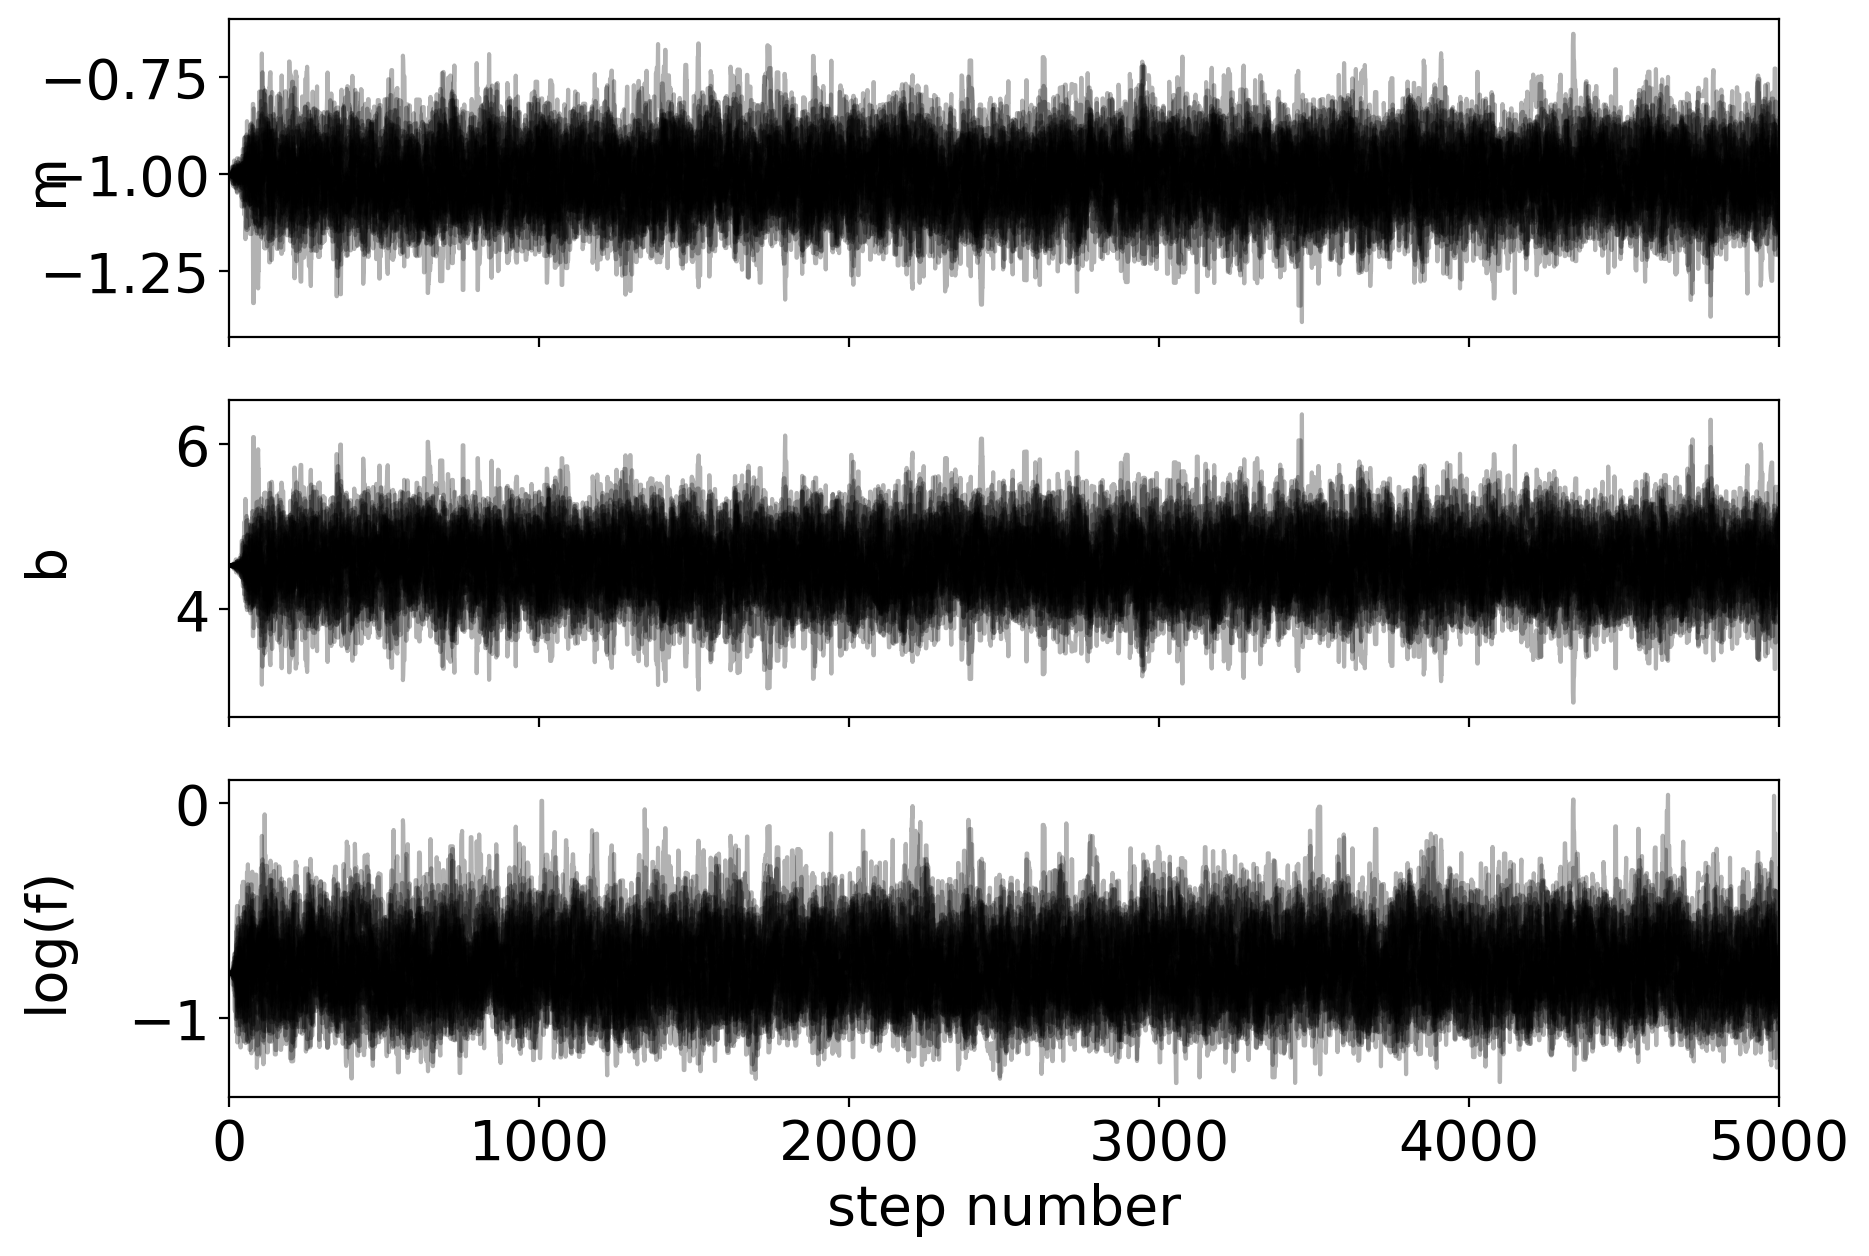

In [19]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The integrated autocorrelation time gives us an estimate of how many steps are required
for the chain to "forget" where it started.

In [20]:
tau = sampler.get_autocorr_time()
tau

array([41.83761694, 41.70432255, 37.70694423])

It's not unreasonable to throw away a few times this number as "burn in", so lets
discard the initial 100 steps, thin by about half the autocorrelation time (15 steps),
and flatten the chain so we have a flat list of samples:

In [22]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples.shape


(10432, 3)

### Results
Now we have a list of samples, we can make on of the most useful plots with MCMC
results: a corner plot.

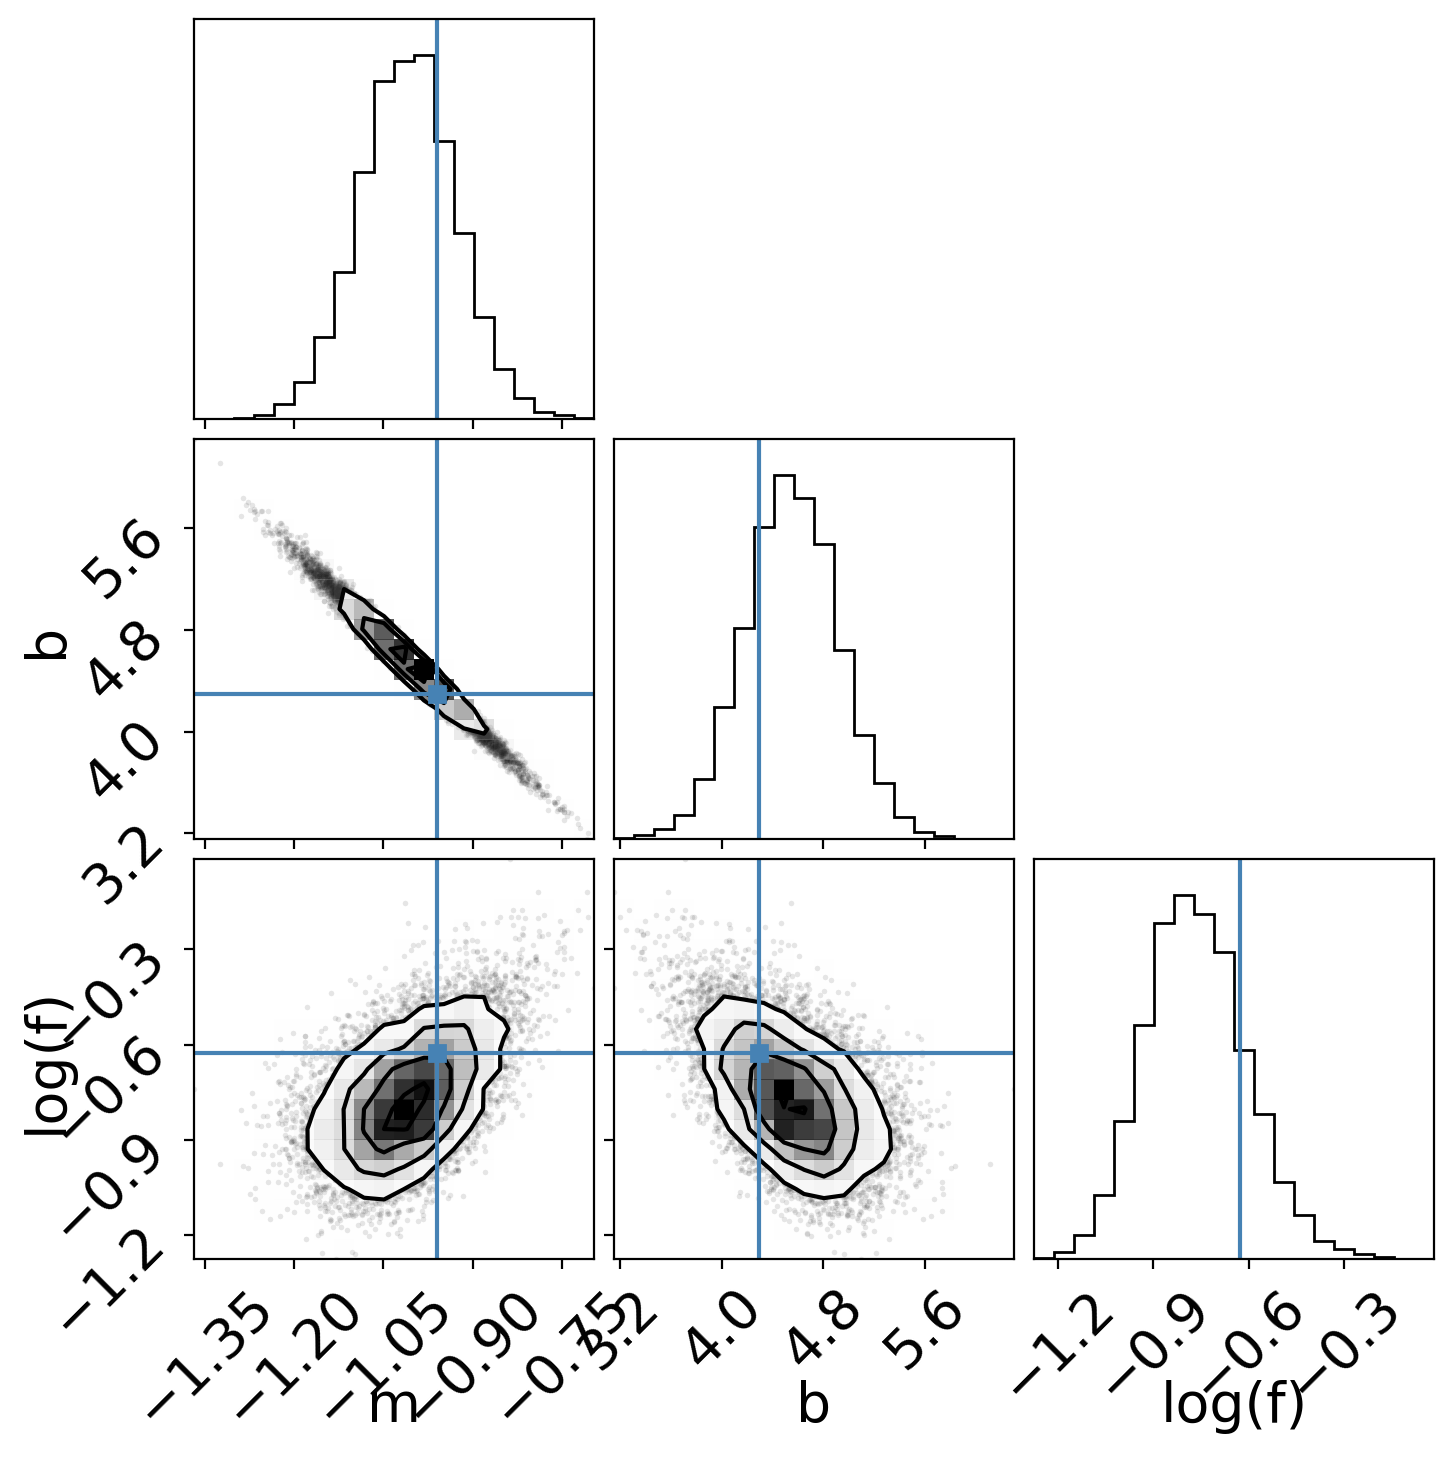

In [23]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)])
plt.show(fig)

The corner plot shows all the one and two dimensional projections of the posterior
probability distributions of your parameters. This is useful because it quickly demonstrates
all of the covariances between parameters. Also, the way that you find the marginalized
distribution for a parameter or set of parameters using the results of the MCMC chain
is to project the samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each parameter
independently in the histograms along the diagonal and then the marginalized two
dimensional distributions in the other panels.

In this case, we've set up the blue lines to pick out the "true" values which we 
started with. 

Another diagnostic plot is the projection of your results into the space of the observed data.
To do this, we choose a few (say 100 in this case) samples from the chain and plot them on top
of the data points:

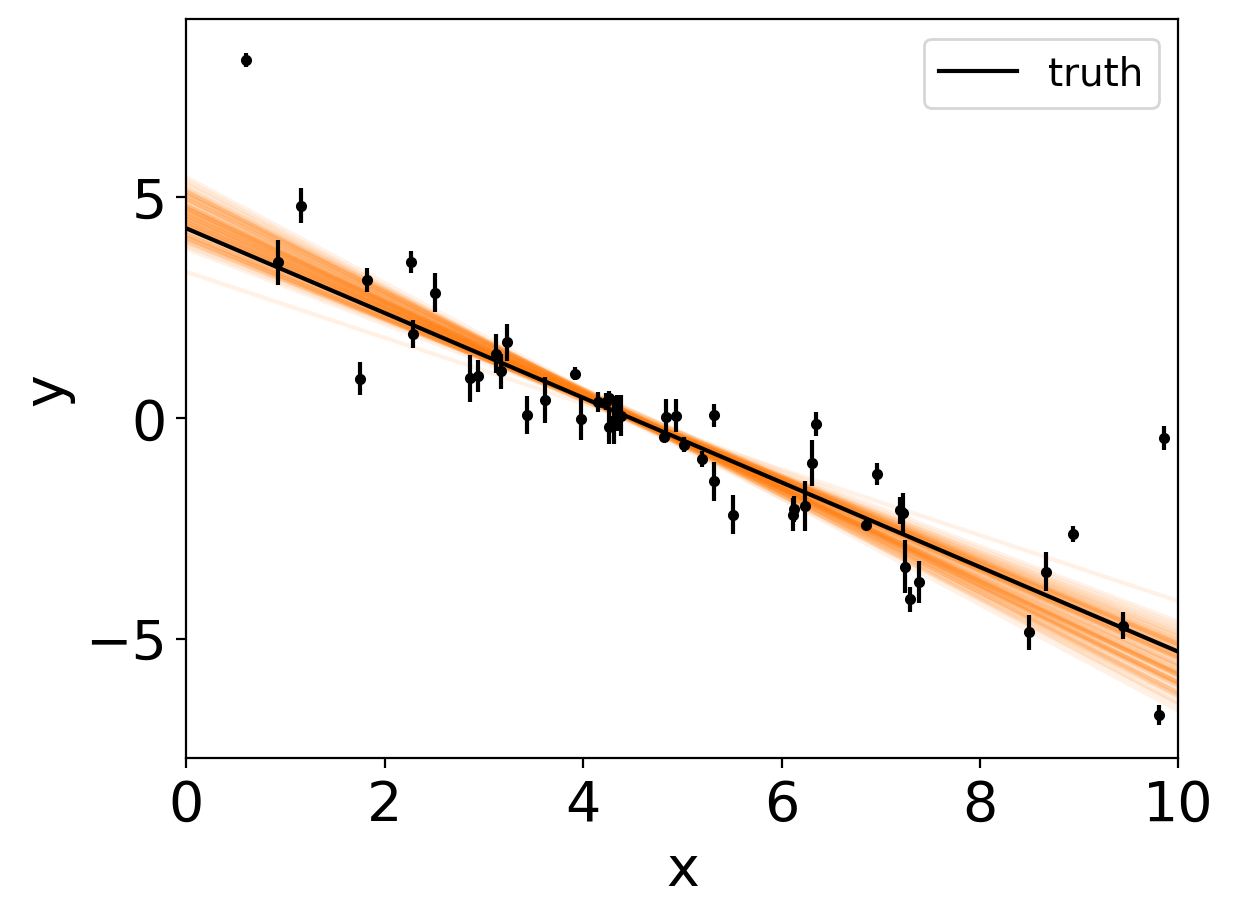

In [14]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract? There are a few
different options for this but my favorite is to quote the uncertainties based on the 16th,
50th, and 84th percentiles of the samples in the marginalized distributions. To compute
these numbers for this example, you would run:

In [15]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
for i in range(ndim):
    mean, sigma = np.mean(flat_samples[:, i]), np.std(flat_samples[:, i])
    txt = "\mathrm{{{2}}} = {0:.3f} \pm {1:.3f}".format(mean, sigma, labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>